<a href="https://www.kaggle.com/toygarr/sentiment-aware-model-to-classify-tweets-real-time?scriptVersionId=83741436" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment-aware Contextual Model for Tweets

Sentiment Analysis has an important role in today’s world especially for private companies
which hold lots of data. The massive amount of data generated by Twitter present a unique
opportunity for sentiment analysis. However, it is challenging to build an accurate predictive
model to identify sentiments, which may lack sufficient context due to the length limit. In
addition, sentimental and regular ones can be hard to separate because of word ambiguity. In
this notebook, I will be proposing the phases of text pre-processing, visual analysis and modeling.

***I tried to keep code as simple as possible to remain understandable.***

Proposed **BERT-CNN-BiLSTM-FC** learning pipeline, which consists of **three sequential modules**.<br />
BERT produces competitive results, and can be considered as one of the new electricity of natural
language processing tasks such as sentiment analysis, named entity recognition (NER), and topic
modeling. The combination of CNN and BiLSTM models requires a particular design, since each
model has a specific architecture and its own strengths:<br />
• BERT is utilized to transform word tokens from the raw Tweet messages to contextual word
embeddings.<br />
• CNN is known for its ability to extract as many features as possible from the text.<br />
• BiLSTM keeps the chronological order between words in a document, thus it has the ability
to ignore unnecessary words using the delete gate.<br />
• Fully Connected Layers give robustness to decrease unsteadiness of results in hard cases. 

## > If you find my work useful please don't forget to **Upvote!**  so it can reach more people.


**References:**<br />
1) [A Sentiment-Aware Contextual Model for Real-Time Disaster Prediction Using Twitter Data](https://www.mdpi.com/1999-5903/13/7/163/htm) -> The idea comes from and really worth to check on, however, i am not using the same model.<br />
2) [Automatic identification of eyewitness messages on twitter during disasters](https://reader.elsevier.com/reader/sd/pii/S0306457319303590?token=985D740724AEDB812611486EBAD3B68FA4393520D4DCD96FDADE4A642A9805D728945987C1BBBE0FDAA8EC3684E372C7&originRegion=eu-west-1&originCreation=20210920022341)<br />
3) [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)<br />
4) [BERT: Pre-training of Deep Bidirectional Transformers for Language
               Understanding](http://arxiv.org/abs/1810.04805)<br />
5) [LMAES' Notebook](https://www.kaggle.com/lmasca/disaster-tweets-using-bert-embeddings-and-lstm)<br />
6) [PAOLO RIPAMONTI's Notebook](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

In [1]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not actively using
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools


# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


2021-12-28 10:43:23.177685: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-28 10:43:23.177805: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"

# Read Dataset

### Dataset details:
http://help.sentiment140.com the site is pretty old and most of the links are broken, however, check out for more detail.

Latest availability of dataset: https://www.kaggle.com/kazanova/sentiment140

@ONLINE {Sentiment140, <br />
    author = "Go, Alec and Bhayani, Richa and Huang, Lei", <br />
    title  = "Twitter Sentiment Classification using Distant Supervision", <br />
    year   = "2009", <br />
    url    = "http://help.sentiment140.com/home"
}

*According to the creators of the dataset:* \
"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search".


The data is a CSV with emoticons removed. Data file format has 6 fields:
* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet
* date: the date of the tweet
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted
* text: the text of the tweet

In [3]:
# Read the data
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', 
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS)

In [4]:
# Raw data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Map target label to String
* 0 -> NEGATIVE
* 2 -> NEUTRAL
* 4 -> POSITIVE

In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 723 ms, sys: 22.6 ms, total: 746 ms
Wall time: 750 ms


# Cleaning Text

So basically what we will do here:

* Remove urls, html tags and punctuations

In [7]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)



def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [8]:
df.head()

,target,ids,date,flag,user,text,text_clean
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot Awww thats a bummer You shoulda ...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


# Visualizing the Data

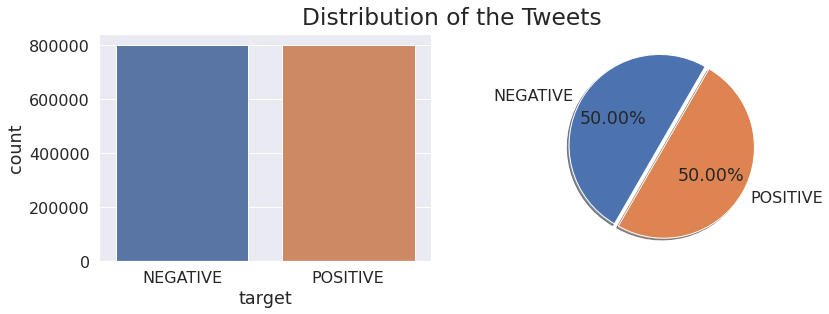

In [9]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=[NEGATIVE, POSITIVE],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

________________

As a quick and easy observation, we can say that dataset has no imbalanced label problem. Negative and Positive labels are equal. The situation of equilibrium will let model to learn more accurate. However, should not be forgotten, dataset might has lots of mislabelled text due to way of collection which has only parameter as **":)" : positive** or **":(" : negative**. The problem is that lots of user may send ":)" or ":(" ironically.  

> An example: "u look like a sh\*t today :)"

This problem may decrease the accuracy, however, end of the day we're creating a sentiment-aware model depending on the words.

_____

In [10]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df_x, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df_x.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

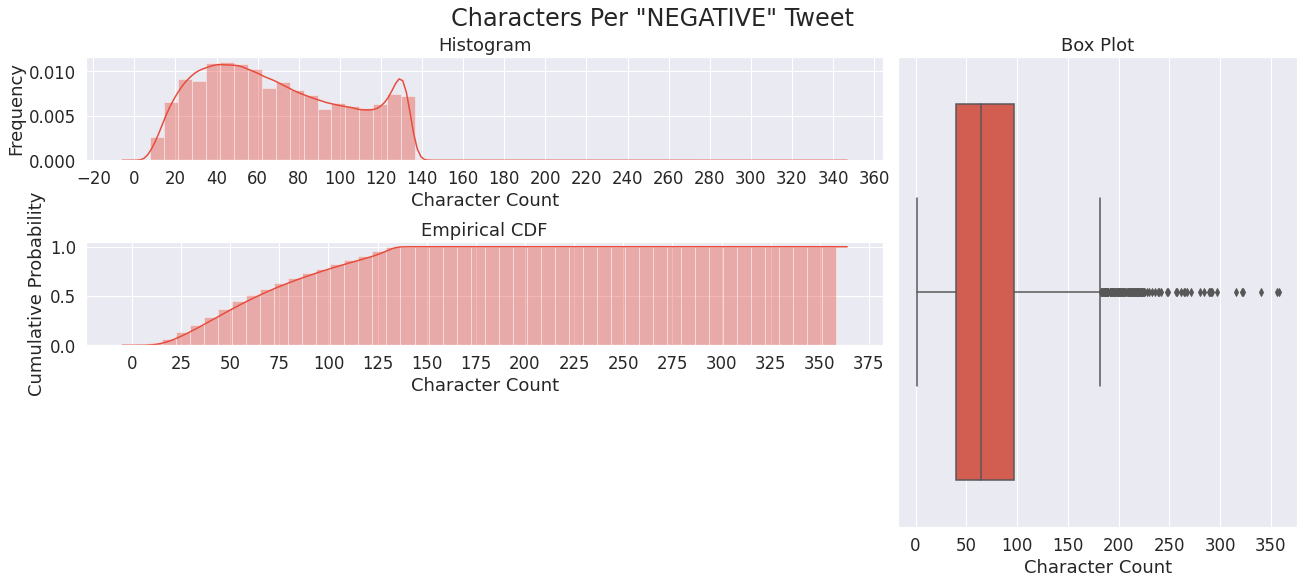

In [11]:
plot_dist3(df[df['target'] == 'NEGATIVE'], 'Character Count',
           'Characters Per "NEGATIVE" Tweet')

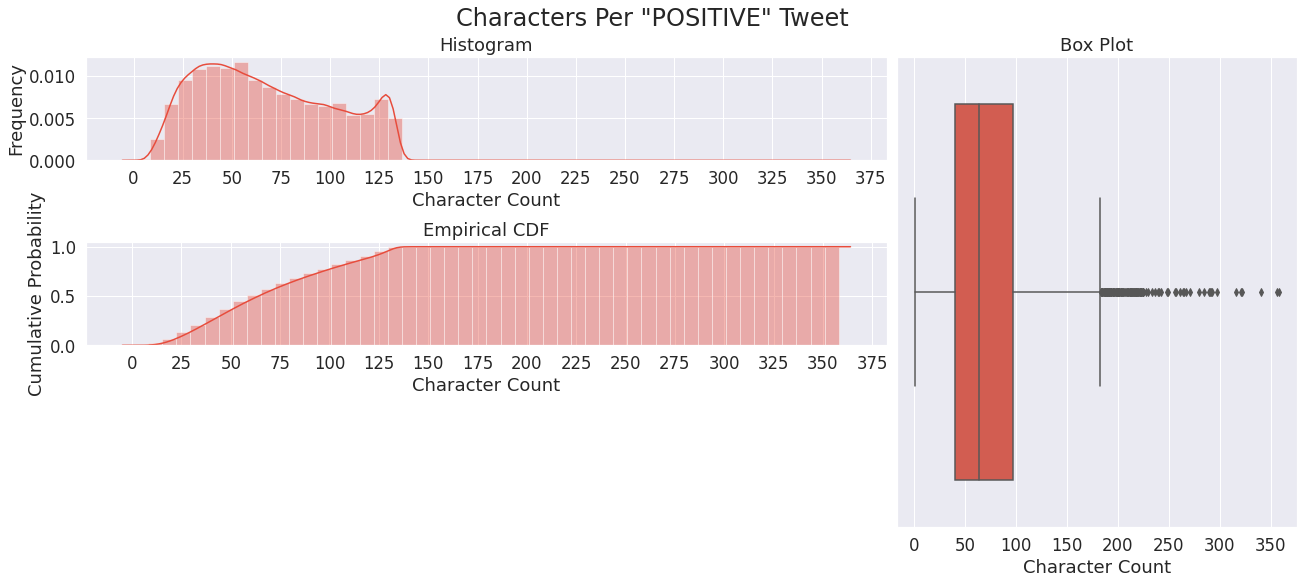

In [12]:
plot_dist3(df[df['target'] == "POSITIVE"], 'Character Count',
           'Characters Per "POSITIVE" Tweet')

# Setup environment to build model

In [13]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2021-12-28 10:44:50.743704: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-28 10:44:50.746858: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-28 10:44:50.746896: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-28 10:44:50.746934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ea8aee2264a7): /proc/driver/nvidia/version does not exist
2021-12-28 10:44:50.750160: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [15]:
# hyperparameters
max_length = 140
batch_size = 512

In [16]:
# Bert Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

# Splitting the data

In [17]:
train_df, test = train_test_split(df, test_size=0.05, random_state=42)
x_train, dev = train_test_split(train_df, test_size=0.05, random_state=42)

___

### Data Decrease
I will be taking 400k of the train data because i want to show results by predicting crawled tweets at the end. When we use all the 1.6m data, Kaggle's does not allow us to scrape tweets properly. Kernel explodes in other terms.

In [18]:
train = x_train[:400000]

# Label Encoder

In [19]:
labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [20]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (400000, 1)
y_test (80000, 1)


In [21]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [22]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# Proposed Model

In [23]:
def bert_tweets_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    x = tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_word_ids, outputs)
   
    
    return model

In [24]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 140)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 108310272 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 140, 768)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 138, 64)           147520    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 138, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0     

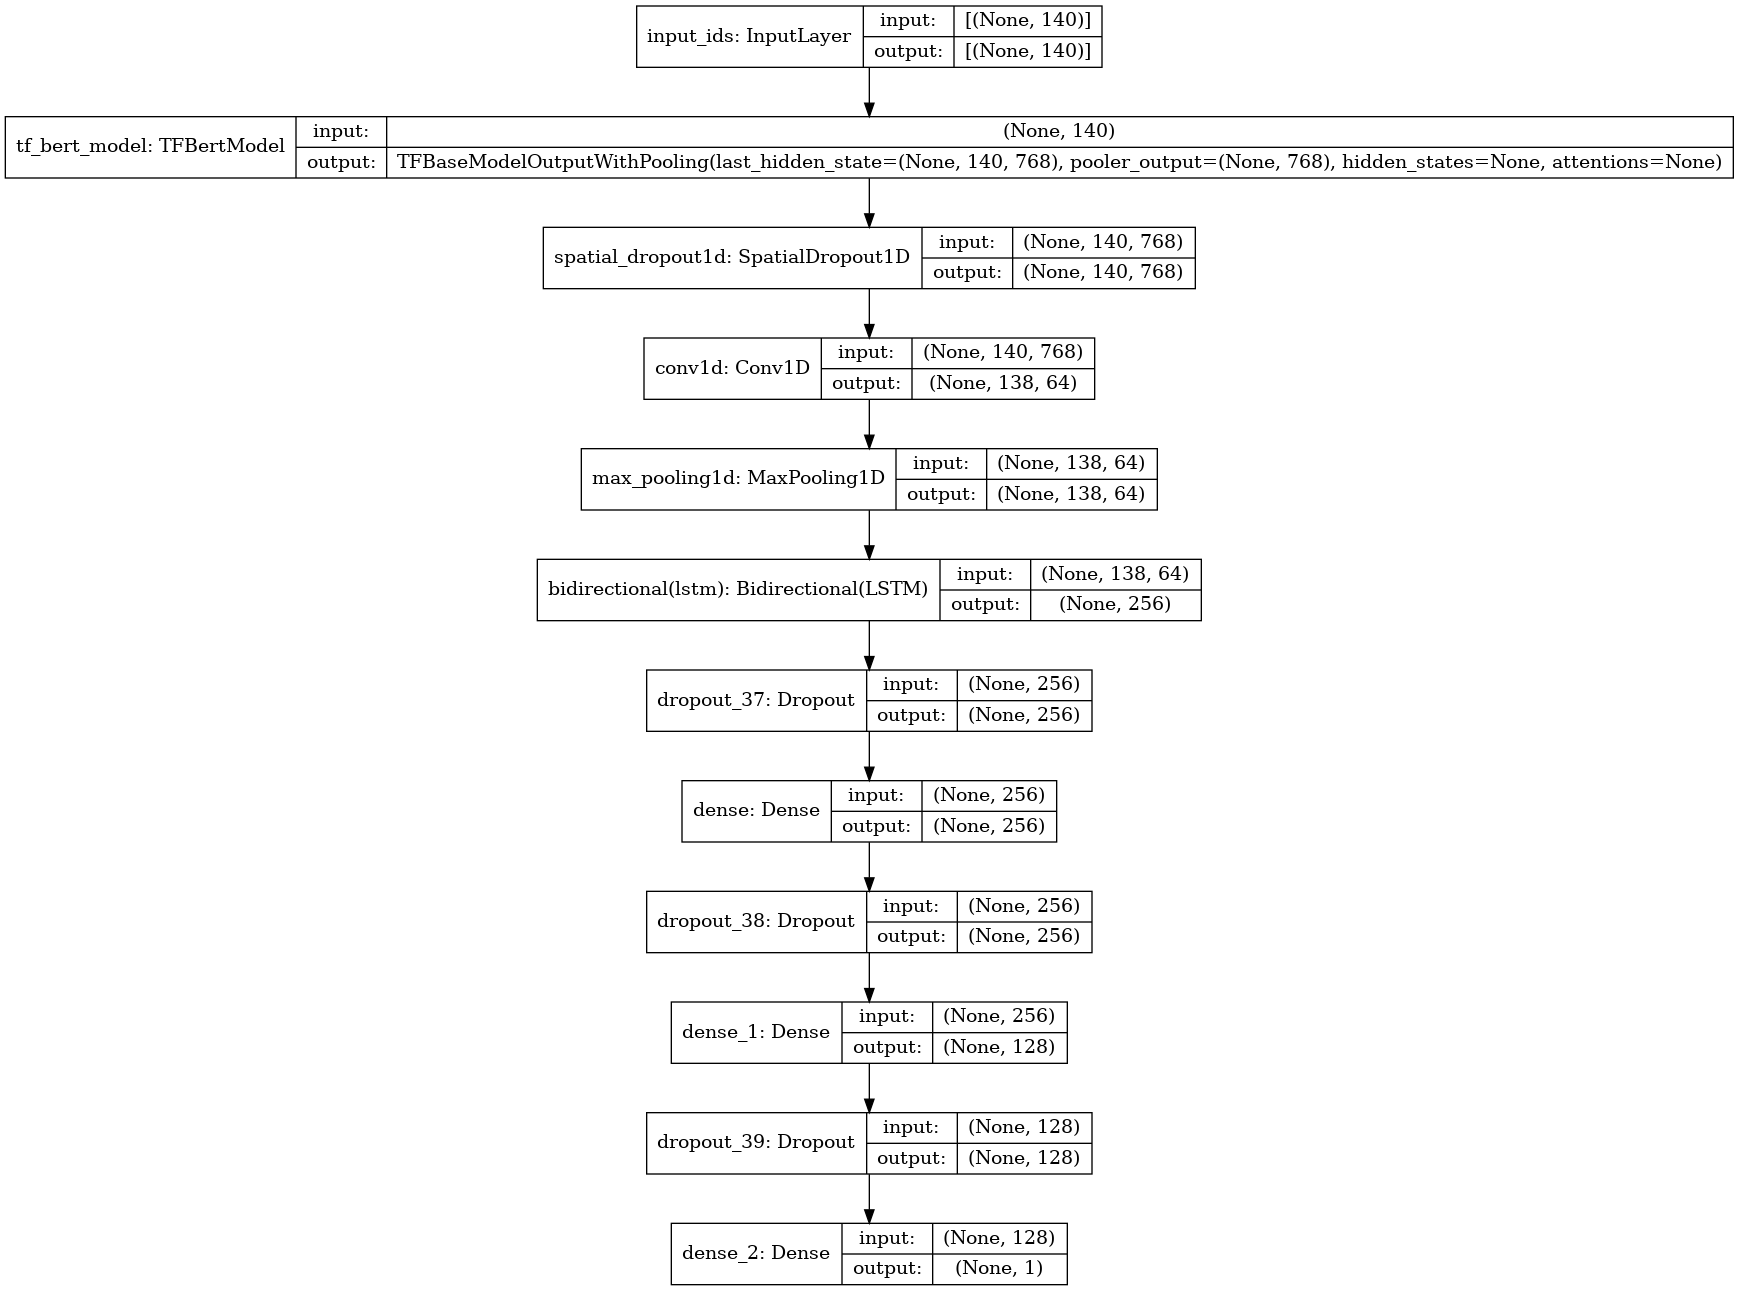

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [26]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1)
    #callbacks=[tf.keras.callbacks.EarlyStopping(
    #            patience=6,
    #            min_delta=0.05,
    #            baseline=0.7,
    #            mode='min',
    #            monitor='val_accuracy',
    #            restore_best_weights=True,
    #            verbose=1)
    #          ])

Epoch 1/3
782/782 [==============================] - 409s 422ms/step - loss: 0.5087 - accuracy: 0.7343 - val_loss: 0.3736 - val_accuracy: 0.8328
Epoch 2/3
782/782 [==============================] - 270s 345ms/step - loss: 0.3769 - accuracy: 0.8337 - val_loss: 0.3600 - val_accuracy: 0.8404
Epoch 3/3
782/782 [==============================] - 270s 345ms/step - loss: 0.3493 - accuracy: 0.8471 - val_loss: 0.3542 - val_accuracy: 0.8432


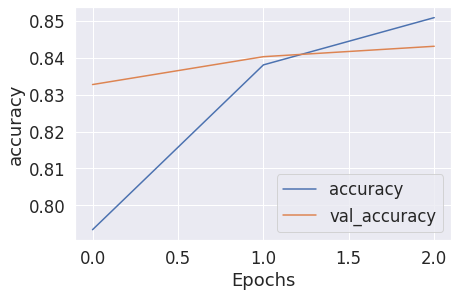

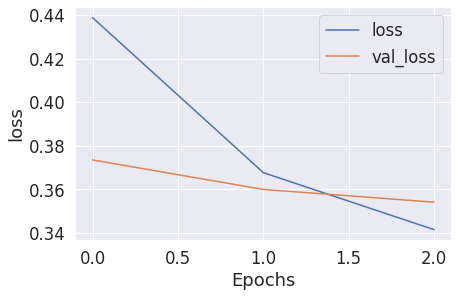

In [27]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Predict Manually Before Using Test Data

Decoder to be able to see results as labelled negative, positive or neutral

In [58]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [29]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [30]:
predict("I hate the economy")

{'label': 'NEGATIVE',
 'score': 0.0076500773429870605,
 'elapsed_time': 8.20638108253479}

In [31]:
predict("I would prefer writing a crawler to create this dataset but i couldn't")

{'label': 'NEGATIVE',
 'score': 0.015539079904556274,
 'elapsed_time': 0.38393115997314453}

In [32]:
predict("I LOVE NLP")

{'label': 'POSITIVE',
 'score': 0.8741670846939087,
 'elapsed_time': 0.42804813385009766}

In [33]:
predict("life is really strange isn't it? just the combination of laugh and cry")

{'label': 'POSITIVE',
 'score': 0.8946133852005005,
 'elapsed_time': 0.3976705074310303}

In [34]:
predict("ESL is the world's largest esports company, leading the industry across the most popular video games.\
        We're proud they've chosen us to help them deliver their launchers to gamers all over the world. Read the full review")

{'label': 'POSITIVE',
 'score': 0.9840901494026184,
 'elapsed_time': 0.40712428092956543}

In [35]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

{'label': 'POSITIVE',
 'score': 0.9948157072067261,
 'elapsed_time': 0.4117119312286377}

In [36]:
predict("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

{'label': 'NEUTRAL',
 'score': 0.5769292116165161,
 'elapsed_time': 0.4209938049316406}

In [37]:
predict("i don't say this lightly - hemingway's life ended by suicide. His life was actually a loss")

{'label': 'NEGATIVE',
 'score': 0.28644007444381714,
 'elapsed_time': 0.40560221672058105}

In [38]:
predict("these r not ur problems dear!!! these r ur x bf's commitng suicide")

{'label': 'NEGATIVE',
 'score': 0.07155805826187134,
 'elapsed_time': 0.5090491771697998}

In [39]:
predict("i hve no idea about that i love the uni or not")

{'label': 'POSITIVE',
 'score': 0.754216730594635,
 'elapsed_time': 0.40343308448791504}

In [40]:
predict("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

{'label': 'POSITIVE',
 'score': 0.8340874910354614,
 'elapsed_time': 0.40235424041748047}

In [41]:
predict("I found some old Reddit post in which one guy from english-speaking country complains that\
the names in The Witcher books are 'too difficult' and non- intuitive for english speaker.\
Man, let me introduce you to 'The books werent written only/for english speakers.'' #witcher")

{'label': 'NEGATIVE',
 'score': 0.25816088914871216,
 'elapsed_time': 0.4683384895324707}

In [42]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

{'label': 'NEGATIVE',
 'score': 0.12137988209724426,
 'elapsed_time': 0.444072961807251}

In [43]:
predict("fun fact: ai cannot predict everything right")

{'label': 'POSITIVE',
 'score': 0.8002768754959106,
 'elapsed_time': 0.40268969535827637}

In [44]:
predict("brain is just a machine")

{'label': 'NEUTRAL',
 'score': 0.4515431821346283,
 'elapsed_time': 0.3937642574310303}

# Evaluate

In [45]:
test_encoded = bert_encode(test.text_clean)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

y_pred = []
predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()

In [46]:
%%time
scores = model.evaluate(test_encoded, y_test, batch_size=batch_size)
print()
print("ACCURACY:",scores[1])
print("LOSS:",scores[0])

157/157 [==============================] - 19s 119ms/step - loss: 0.3532 - accuracy: 0.8435

ACCURACY: 0.8434624671936035
LOSS: 0.3531826436519623
CPU times: user 1.57 s, sys: 262 ms, total: 1.84 s
Wall time: 19 s


In [59]:
y_pred = [decode_sentiment(predicted_tweets) for predicted_tweets in scores]

In [48]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

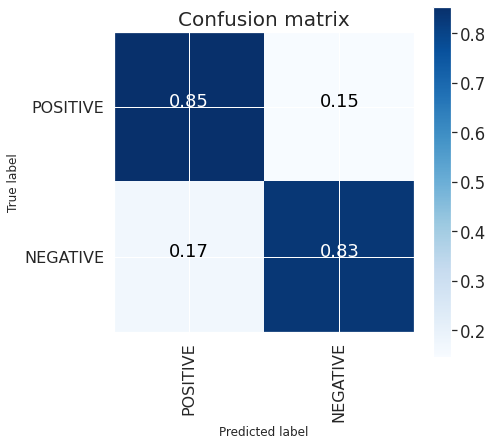

In [49]:
cnf_matrix = confusion_matrix(y_test, predicted_tweets_binary)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=train.target.unique(), title="Confusion matrix")
plt.show()

# Classification Report

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.4f' % precision_score(y_test, predicted_tweets_binary))
print('Recall: %.4f' % recall_score(y_test, predicted_tweets_binary))
print('Accuracy: %.4f' % accuracy_score(y_test, predicted_tweets_binary))
print('F1 Score: %.4f' % f1_score(y_test, predicted_tweets_binary))
print(classification_report(y_test, predicted_tweets_binary))

Precision: 0.8504
Recall: 0.8336
Accuracy: 0.8435
F1 Score: 0.8419
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     39999
           1       0.85      0.83      0.84     40001

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



# Error Analysis

In [51]:
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [52]:
df = pd.DataFrame(test.text, columns=["text"])
df['ids'] = test.ids
df["actual"] = test.target
df["predicted"] = predicted_tweets_binary
df.predicted = df.predicted.apply(lambda x: decode_sentiment(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
incorrect = df[df["actual"] != df["predicted"]]
incorrect.head(20)

,text,ids,actual,predicted
1380171,@PerezHilton Zach makes me pee sitting down! And I'm a grown gay man!,2052206835,POSITIVE,NEGATIVE
986772,"@wizely lol, calm down. i got a 30day loan offer for only 1500%",1834598659,POSITIVE,NEGATIVE
1586084,"i'm feeling quite sleepy today, wish i could stay in bed today...but OK! is my LAST YEAR, so let's go to school",2190762188,POSITIVE,NEGATIVE
977527,No woooooork tomorrrow&amp;tuesday,1833745318,POSITIVE,NEGATIVE
305246,"@RocDoogie I am, I'll admit... maybe I'll feel better tomorrow, yo! Down 4 studio time??",1999945855,NEGATIVE,POSITIVE
930710,"@Konstantine I said &quot;scar,&quot; sweetie.",1770583669,POSITIVE,NEGATIVE
617079,@team_allen jealous! I'm yet to find a local chinese i'm satisfied with,2226909167,NEGATIVE,POSITIVE
1066232,"If anyone wanted to attend TEDMED but can't make the date, I'll happily take your place, and will live-blog it for you too",1965260370,POSITIVE,NEGATIVE
336219,I shame the name of female lol Alright. Shower then sleep then get up in like 5 hours.,2013951848,NEGATIVE,POSITIVE
1328830,"@disil429 Fine. Kinders coughing again, so not a lot of sleep. Weather's good, though, that's the main thing",2015570824,POSITIVE,NEGATIVE


In [53]:
correct = df[df['actual'] == df['predicted']]
correct.head(10)

,text,ids,actual,predicted
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,2200003196,NEGATIVE,NEGATIVE
750,"@misstoriblack cool , i have no tweet apps for my razr 2",1467998485,NEGATIVE,NEGATIVE
766711,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",2300048954,NEGATIVE,NEGATIVE
285055,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,1993474027,NEGATIVE,NEGATIVE
705995,upper airways problem,2256550904,NEGATIVE,NEGATIVE
379611,Going to miss Pastor's sermon on Faith...,2052380495,NEGATIVE,NEGATIVE
1189018,on lunch....dj should come eat with me,1983449090,POSITIVE,POSITIVE
667030,@piginthepoke oh why are you feeling like that?,2245479748,NEGATIVE,NEGATIVE
93541,gahh noo!peyton needs to live!this is horrible,1770705699,NEGATIVE,NEGATIVE
1097326,@mrstessyman thank you glad you like it! There is a product review bit on the site Enjoy knitting it!,1970386589,POSITIVE,POSITIVE


_____

# Fetching data from Twitter
To get started,

* Import the twint package as follows.

## We stored the related tweets in the .csv or .json file which is really fast and cool

So how we will read from csv/json file to use for our purpose ? 

In [54]:
!pip install twint
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
import twint
import nest_asyncio

     |████████████████████████████████| 263 kB 966 kB/s eta 0:00:01
     |████████████████████████████████| 385 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 20.5 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 3.7 MB/s  eta 0:00:01
  Created wheel for twint: filename=twint-2.1.20-py3-none-any.whl size=33930 sha256=06177af96353f9a5c5d3a6fdd95754065bea19d8f96668a9a4d0aa5f2314d3dc
  Stored in directory: /root/.cache/pip/wheels/44/fc/77/99887a36b5c265a87516158858697d1a0b8f32c4d4dbddbb24
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=e40d71db049528e6f9c3336e19e411afe311f8119a9a0604cca0b2fcf4ad9823
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for googletransx: filename=googletransx-2.4.2-py3-none-any.whl size=15968 sha256=d2dd5ed517d7e091e4fba90a7f49eaee96c26779a6c11da6d18ac3590bbd442d
  Stored in directory: /root/.cache

In [55]:
c = twint.Config()

c.Search = "grammys" #keyword for search
c.Limit = 20 #limit of the number of tweets which will be extracted
c.Store_csv = True 
c.Output = 'grammys_tweet_data.csv'

nest_asyncio.apply()
twint.run.Search(c)

1475785536845586432 2021-12-28 11:07:45 +0000 <bangtan1201087> @peppercqueen @LManoyban @RecordingAcad Are you talking about Lisa?
1475785108842033154 2021-12-28 11:06:03 +0000 <BraThierry17> @RecordingAcad @shattawalegh so sad
1475784368077475840 2021-12-28 11:03:06 +0000 <ivyparkspr> This was during the most recent Grammys
1475783621319483397 2021-12-28 11:00:08 +0000 <Cristin68018373> @RecordingAcad Para mi esa canción es #FlyAway de ☺ @dimash_official #BeWithMe
1475783588138438660 2021-12-28 11:00:00 +0000 <UMUSICPH> Which one is your fave from producer and hitmaker #bennyblanco? 🎧🔥 🎶  https://t.co/VkBjLMdAng  #Grammys #JustinBieber #GracieAbrams #marshmello #vancejoy  https://t.co/fa62ejEasX
1475783559747092481 2021-12-28 10:59:54 +0000 <flameofdesires> admiro a autoestima dos anitters de tentarem se crescer pra cima da rosalía quando a rosa mesmo cantando em catalão tem certificado na RIAA americana, música charteando por mais de 2 semanas na hot 100 e grammys, coisas que a it a 

In [56]:
crawled_data = pd.read_csv("grammys_tweet_data.csv")
#crawled_data = pd.read_json("tweet_data.json", lines=True)
pd.options.display.max_columns=36
crawled_data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1475785536845586432,1475151926299967489,2021-12-28 11:07:45 UTC,2021-12-28,11:07:45,0,1464906515404537861,bangtan1201087,방탄소년단,NaN,@peppercqueen @LManoyban @RecordingAcad Are you talking about Lisa?,en,[],[],[],0,0,0,[],[],https://twitter.com/bangtan1201087/status/1475785536845586432,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'peppercqueen', 'name': 'Pepper C', 'id': '1266390434357694464'}, {'screen_name': 'LManoyban', 'name': 'Kuyseee', 'id': '1413036244985024513'}, {'screen_name': 'RecordingAcad', 'name': 'Recording Academy / GRAMMYs', 'id': '17243213'}]",NaN,NaN,NaN,NaN
1,1475785108842033154,1475537466652344320,2021-12-28 11:06:03 UTC,2021-12-28,11:06:03,0,751405591105380352,brathierry17,Thierry ❤,NaN,@RecordingAcad @shattawalegh so sad,en,[],[],[],0,0,0,[],[],https://twitter.com/BraThierry17/status/1475785108842033154,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'RecordingAcad', 'name': 'Recording Academy / GRAMMYs', 'id': '17243213'}]",NaN,NaN,NaN,NaN
2,1475784368077475840,1475784365938397184,2021-12-28 11:03:06 UTC,2021-12-28,11:03:06,0,935481588636303360,ivyparkspr,Halls of IVY,NaN,This was during the most recent Grammys,en,[],[],[],0,0,1,[],[],https://twitter.com/ivyparkspr/status/1475784368077475840,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1475783621319483397,1475537466652344320,2021-12-28 11:00:08 UTC,2021-12-28,11:00:08,0,1440106189992468480,cristin68018373,Cristina Gomez,NaN,@RecordingAcad Para mi esa canción es #FlyAway de ☺ @dimash_official #BeWithMe,es,"[{'screen_name': 'dimash_official', 'name': 'dimash qudaibergen', 'id': '510948637'}]",[],[],0,0,0,"['flyaway', 'bewithme']",[],https://twitter.com/Cristin68018373/status/1475783621319483397,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'RecordingAcad', 'name': 'Recording Academy / GRAMMYs', 'id': '17243213'}]",NaN,NaN,NaN,NaN
4,1475783588138438660,1475783588138438660,2021-12-28 11:00:00 UTC,2021-12-28,11:00:00,0,34180086,umusicph,UMUSIC Philippines,NaN,Which one is your fave from producer and hitmaker #bennyblanco? 🎧🔥 🎶 https://t.co/VkBjLMdAng #Grammys #JustinBieber #GracieAbrams #marshmello #vancejoy https://t.co/fa62ejEasX,en,[],['https://umusicph.lnk.to/TheNomineesAreTP'],[],0,0,1,"['bennyblanco', 'grammys', 'justinbieber', 'gracieabrams', 'marshmello', 'vancejoy']",[],https://twitter.com/UMUSICPH/status/1475783588138438660,False,NaN,1,https://pbs.twimg.com/ext_tw_video_thumb/1475770443327938561/pu/img/2274vM1F6jEod-0P.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


_____
As you can see above we have lots of features which extracted by twint. However, we only need the "tweet" feature which includes the text data of tweets for our purpose.

In [60]:
# prediction of the first 15 extracted tweets
for i in range(15):
    print(crawled_data["tweet"][i])
    print(predict(crawled_data["tweet"][i]))
    print("\n")

@peppercqueen @LManoyban @RecordingAcad Are you talking about Lisa?
{'label': 'POSITIVE', 'score': 0.7433716654777527, 'elapsed_time': 0.4378478527069092}


@RecordingAcad @shattawalegh so sad
{'label': 'NEGATIVE', 'score': 0.0035476088523864746, 'elapsed_time': 0.4229888916015625}


This was during the most recent Grammys
{'label': 'NEUTRAL', 'score': 0.5487651824951172, 'elapsed_time': 0.4002401828765869}


@RecordingAcad Para mi esa canción es #FlyAway de ☺ @dimash_official #BeWithMe
{'label': 'POSITIVE', 'score': 0.7963888645172119, 'elapsed_time': 0.4505488872528076}


Which one is your fave from producer and hitmaker #bennyblanco? 🎧🔥 🎶  https://t.co/VkBjLMdAng  #Grammys #JustinBieber #GracieAbrams #marshmello #vancejoy  https://t.co/fa62ejEasX
{'label': 'POSITIVE', 'score': 0.9858935475349426, 'elapsed_time': 0.4062685966491699}


admiro a autoestima dos anitters de tentarem se crescer pra cima da rosalía quando a rosa mesmo cantando em catalão tem certificado na RIAA americana, 

### If you want to know more about twint, you can checkout this Github link:
https://github.com/twintproject/twint